In [6]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bases import linear, polynomial_1d, polynomial, sinusoidal_1d, sinusoidal, radial
from metrics import MSE
from surrogate_model import SurrogateModel
from error_estimate import holdout_sets, holdout_estimate
from error_estimate import k_fold_cross_validation_sets, k_fold_cross_validation_estimate
from error_estimate import bootstrap_sets, bootstrap_estimate, leave_one_out_bootstrap_estimate, bootstrap_632_estimate

In [2]:
def surrogate(target_func, bases_sets, smoothing = 0.5, range = (-10.0, 10.0)):
    r = range[1] - range[0]
    X = np.linspace(range[0], range[1], max(10, int(r / 0.1)))
    yt = target_func(X)

    plots_per_row = 4
    plotgrid = ((len(bases_sets) // plots_per_row + bool(len(bases_sets) % plots_per_row)), plots_per_row)
    figure, axis = plt.subplots(plotgrid[0], plotgrid[1], figsize=(plotgrid[1] * 6, plotgrid[0] * 6), squeeze=False, sharey=True, sharex=True)
    idx = 0

    df_id = []
    df_r1 = []
    df_r2 = []
    df_r3 = []

    for name, bases in bases_sets.items():
        model = SurrogateModel(bases, smoothing)
        model.fit(X.reshape(-1, 1), yt)
        yp = model.predict(X.reshape(-1, 1))

        df_id.append(name)
        df_r1.append(holdout_estimate(X.reshape(-1, 1), yt, bases, smoothing, MSE))
        df_r2.append(k_fold_cross_validation_estimate(X.reshape(-1, 1), yt, bases, smoothing, MSE))
        df_r3.append(bootstrap_632_estimate(X.reshape(-1, 1), yt, bases, smoothing, MSE))

        axis[idx // plots_per_row, idx % plots_per_row].set_title(name)
        axis[idx // plots_per_row, idx % plots_per_row].plot(X, yt, c='b')
        axis[idx // plots_per_row, idx % plots_per_row].plot(X, yp, c='r')

        idx += 1

    df = pd.DataFrame()
    df['Bases']                   = df_id
    df['Holdout']                 = df_r1
    df['K-fold cross validation'] = df_r2
    df['Bootstrap']               = df_r3
    return df

,Bases,Holdout,K-fold cross validation,Bootstrap
0,polynomial (k = 1),3.548167,3.473488,3.544241
1,polynomial (k = 3),0.278611,0.276902,0.276405
2,polynomial (k = 5),0.194888,0.182638,0.177648
3,polynomial (k = 9),0.065930,0.044453,0.048802


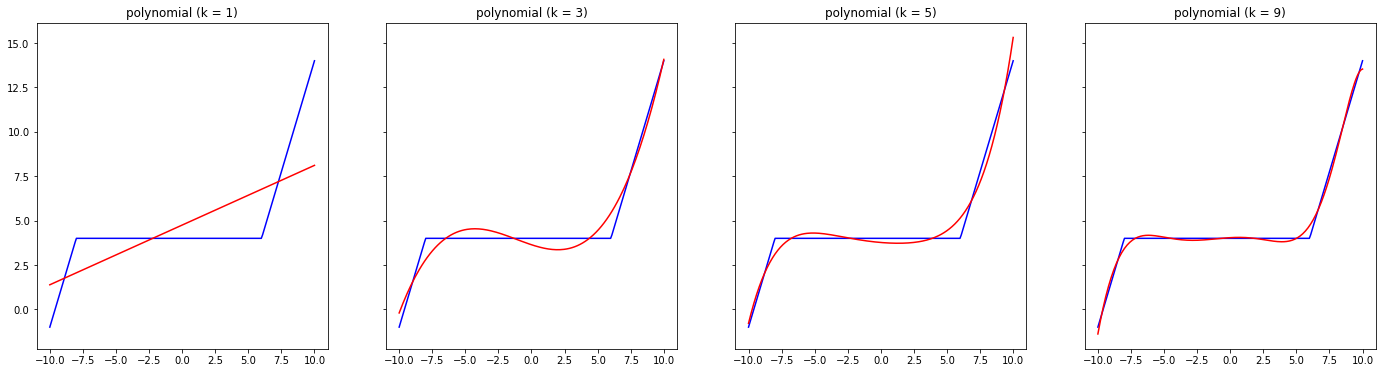

In [10]:
def func(k, a, b, d):
    w0 = k * a - d
    w1 = k * b - d
    return lambda X: np.minimum(np.maximum(d, k * X - w1), k * X - w0)

k = 2.5
a = -8.0
b = 6.0
d = 4.0
bs = {
    'polynomial (k = 1)': polynomial(1, 1),
    'polynomial (k = 3)': polynomial(1, 3),
    'polynomial (k = 5)': polynomial(1, 5),
    'polynomial (k = 9)': polynomial(1, 9),
}
surrogate(func(k, a, b, d), bs)

,Bases,Holdout,K-fold cross validation,Bootstrap
0,sinusoidal (k = 1),0.016971,0.016831,0.016815
1,sinusoidal (k = 2),0.009209,0.008761,0.008809
2,sinusoidal (k = 5),0.004778,0.004108,0.004282
3,sinusoidal (k = 8),0.003445,0.002778,0.003010


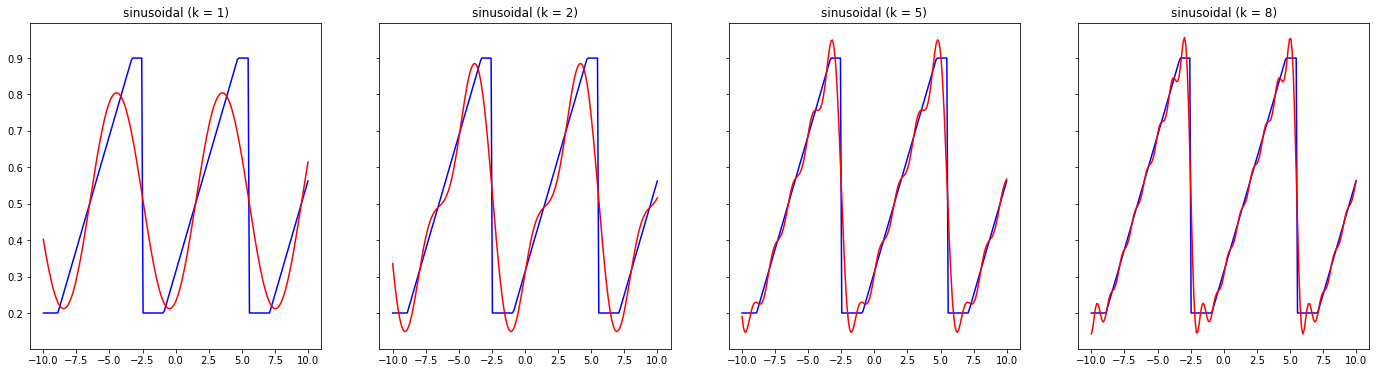

In [11]:
def func(k, c, m, M):
    return lambda X: np.maximum(np.minimum((X + c) / k - np.floor((X + c) / k), M), m)

k = 8.0
c = 2.5
m = 0.2
M = 0.9
bs = {
    'sinusoidal (k = 1)': sinusoidal(1, 1, [c], [c + k]),
    'sinusoidal (k = 2)': sinusoidal(1, 2, [c], [c + k]),
    'sinusoidal (k = 5)': sinusoidal(1, 5, [c], [c + k]),
    'sinusoidal (k = 8)': sinusoidal(1, 8, [c], [c + k])
}
surrogate(func(k, c, m, M), bs)

,Bases,Holdout,K-fold cross validation,Bootstrap
0,"radial (f(r) = r , C = [(-4.0), (0.0)...",0.010031,0.010200,0.010167
1,"radial (f(r) = r^3 , C = [(-4.0), (0.0)...",0.006319,0.006075,0.006094
2,"radial (f(r) = r^2.log(r) , C = [(-4.0), (0.0)...",0.008843,0.008636,0.008784
3,"radial (f(r) = exp(-r^2/5), C = [(-4.0), (0.0)...",0.000419,0.000353,0.000342


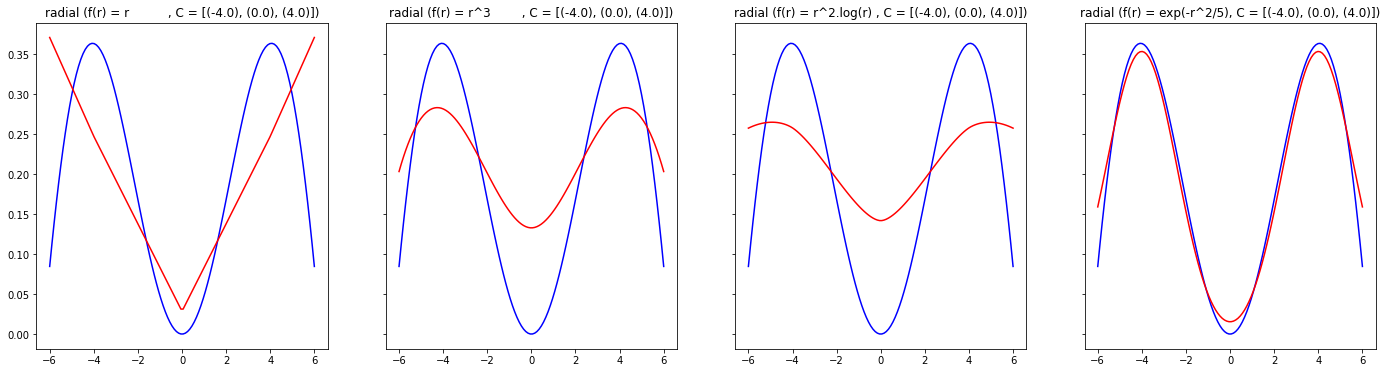

In [40]:
def func():
    return lambda X: 0.1 * X * np.sin(0.5 * X)

w = 2.0
c = 0.5
bs = {
    'radial (f(r) = r'          : radial(lambda r: r                      , [(-4.0), (0.0), (4.0)]),
    'radial (f(r) = r^3'        : radial(lambda r: r ** 3                 , [(-4.0), (0.0), (4.0)]),
    'radial (f(r) = r^2.log(r)' : radial(lambda r: r * r * math.log(r)    , [(-4.0), (0.0), (4.0)]),
    'radial (f(r) = exp(-r^2/5)': radial(lambda r: math.exp(-r ** 2 / 5.0), [(-4.0), (0.0), (4.0)]),
}
surrogate(func(), bs, range=(-6.0, 6.0))